In [45]:
# from synthetic import generate_synthetic_data
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


In [102]:
from mlflux.synthetic import generate_synthetic_data
from mlflux.ann import sample_weights

In [161]:
class FluxDataset(Dataset):
    def __init__(self, N=10000, choice='momentum'):
        
        # Generate data
        self.x1, self.x2, self.y1, self.y2 = generate_synthetic_data(N=N)
        self.X = torch.tensor(np.hstack([np.reshape(self.x1,(-1,1)),np.reshape(self.x2,(-1,1))]).astype('float32'))
        
        # A uniform grid flattened to make prediction maps
        # After making the prediction, Y_pred.reshape([100,100])
        x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-2,2,100)
        x1_mesh, x2_mesh = np.meshgrid(x1_vis,x2_vis,indexing='ij')
        X_uniform = np.hstack([np.reshape(x1_mesh,(-1,1)), np.reshape(x2_mesh,(-1,1))])
        self.X_uniform = torch.tensor(X_uniform.astype('float32'))
        
        # Choice y
        if choice == 'momentum':
            self.Y = torch.tensor(np.reshape(self.y1['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y1['sample']-self.y1['mean'])**2)**0.5
        if choice == 'heat':
            self.Y = torch.tensor(np.reshape(self.y2['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y2['sample']-self.y2['mean'])**2)**0.5
        
    def __len__(self):
        return len(self.x1)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
class FluxDataset1D(Dataset):
    def __init__(self, N=10000, choice='momentum'):
        
        # Generate data
        self.x1, self.x2, self.y1, self.y2 = generate_synthetic_data(N=N)
        self.X = np.reshape(self.x1,(-1,1)).astype('float32')
        
        # A uniform grid flattened to make prediction maps
        # After making the prediction, Y_pred.reshape([100,100])
        x1_vis = np.linspace(0,20,100)
        X_uniform = np.reshape(x1_vis,(-1,1))
        self.X_uniform = torch.tensor(X_uniform.astype('float32'))
        
        # Choice y
        if choice == 'momentum':
            self.Y = torch.tensor(np.reshape(self.y1['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y1['sample']-self.y1['mean'])**2)
        if choice == 'heat':
            self.Y = torch.tensor(np.reshape(self.y2['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y2['sample']-self.y2['mean'])**2)
            
        # Weights?
        self.W = sample_weights(self.X, N)
        
    def __len__(self):
        return len(self.x1)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.W[idx]

In [147]:
# dataset = FluxDataset(N=100000, choice='momentum')
dataset = FluxDataset1D(N=10000, choice='momentum')
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [177]:
from mlflux.ann import ANN
ann_para = {'n_in':1,'n_out':1,'hidden_channels':[16]}
mean_net = ANN(**ann_para)
var_net = ANN(**ann_para)
# mean_net.to('mps')
# var_net.to('mps')

In [179]:
mean_net

ANN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [174]:
''' Variance network trained on log likelihood '''

optimizer_joint = optim.Adam(list(var_net.parameters())+list(mean_net.parameters()), lr=5e-3)
# optimizer_joint = optim.Adam(var_net.parameters(), lr=1e-3)
num_epochs = 100
scheduler = optim.lr_scheduler.MultiStepLR(optimizer_joint, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
log = {'LLLoss': [], 'var': [], 'mean': [], 'lr': []}

loss = nn.GaussianNLLLoss(reduction='none')

for epoch in range(num_epochs):
    LLLoss = 0.
    for i, (inputs, targets, w) in enumerate(dataloader):
        optimizer_joint.zero_grad()
        # Forward pass
        mean = mean_net(inputs)
        var = (var_net(inputs))**2 # squared to predict positive variance
        # likelihood = loss(targets, mean, var).mean()   
        likelihood = torch.sum(loss(targets, mean, var)*w)   
        # Backward and optimize (var and mean net)
        likelihood.backward() # TODO: Only need to call this once right?
        optimizer_joint.step()
        LLLoss += likelihood.item() * len(inputs)   
        
    scheduler.step()     

    LLLoss = LLLoss / len(dataset)
    var = (var_net(dataset.X_uniform))**2
    mean = mean_net(dataset.X_uniform)
    log['LLLoss'].append(LLLoss)
    log['var'].append(var.detach())
    log['mean'].append(mean.detach())
    log['lr'].append(scheduler.get_lr())
    
    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {LLLoss:.8f}")

Epoch [1/100], Loss: -0.00972162
Epoch [2/100], Loss: -0.01007962
Epoch [3/100], Loss: -0.01059598
Epoch [4/100], Loss: -0.01117932
Epoch [5/100], Loss: -0.01193705
Epoch [6/100], Loss: -0.01293425
Epoch [7/100], Loss: -0.01423580
Epoch [8/100], Loss: -0.01615425
Epoch [9/100], Loss: -0.01944661
Epoch [10/100], Loss: -0.02474968
Epoch [11/100], Loss: -0.02574736
Epoch [12/100], Loss: -0.02635626
Epoch [13/100], Loss: -0.02697593
Epoch [14/100], Loss: -0.02770931
Epoch [15/100], Loss: -0.02827474
Epoch [16/100], Loss: -0.02838495
Epoch [17/100], Loss: -0.02883822
Epoch [18/100], Loss: -0.02959830
Epoch [19/100], Loss: -0.02997048
Epoch [20/100], Loss: -0.03043605
Epoch [21/100], Loss: -0.03070475
Epoch [22/100], Loss: -0.03059426
Epoch [23/100], Loss: -0.03115960
Epoch [24/100], Loss: -0.03135481
Epoch [25/100], Loss: -0.03243886
Epoch [26/100], Loss: -0.03229012
Epoch [27/100], Loss: -0.03263301
Epoch [28/100], Loss: -0.03307497
Epoch [29/100], Loss: -0.03304059
Epoch [30/100], Loss: -

Text(0.5, 0, 'Epoch')

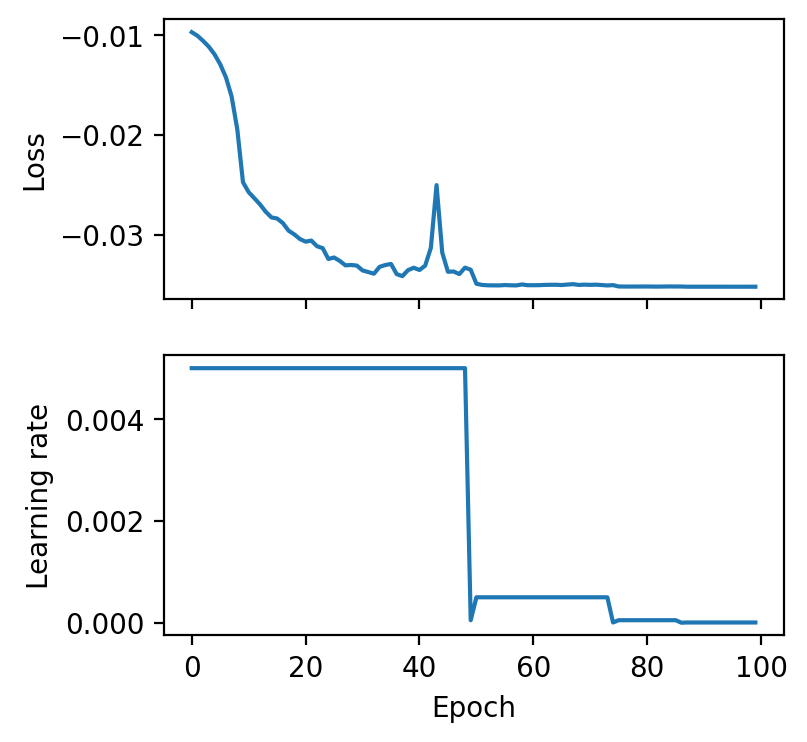

In [175]:
fig, axes = plt.subplots(2,1,sharex=True,figsize=[4,4],dpi=200)
axes[0].plot(log['LLLoss'])
axes[0].set_ylabel('Loss')
axes[1].plot(log['lr'])
axes[1].set_ylabel('Learning rate')
axes[1].set_xlabel('Epoch')

In [204]:
x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-2,2,100)
x1_mesh,x2_mesh = np.meshgrid(x1_vis,x2_vis,indexing='ij')

In [16]:
def plot_epoch(epoch=10, xaxis=1):
    ''' Input:
            xaxis: the x axis variable to display. The prediction of the mean is then 
            averaged along the other dimensions. 0: wind speed; 1: temp diff. 
    '''
    plt.figure(figsize=(4,4))
    plt.plot(dataset.X[:2000, xaxis], dataset.Y[:2000], '.', label='training \ndata')

    mean = log_var['mean'][epoch]
    std = np.sqrt(log_var['var'][epoch])

    dims = [0,1] # for total dimension 2. TODO: refine it later
    dims.remove(xaxis) # axis except for the one specified
    mean_aver = np.average(mean.reshape(100,100), axis=tuple(dims)); std_aver = np.average(std.reshape(100,100), axis=tuple(dims))
    
    if xaxis == 0:
        xplot = dataset.X_uniform[:,xaxis].reshape(100,100)[0]
    elif xaxis == 1:
        xplot = dataset.X_uniform[:,xaxis].reshape(100,100)[:,0]
        
    plt.plot(xplot,mean_aver,'-', lw=1, color='k', label='Expectation')
    plt.plot(xplot,mean_aver-std_aver,'--', lw=1, color='k', label='$\pm \sigma$')
    plt.plot(xplot,mean_aver+std_aver,'--', lw=1, color='k')
        
#     plt.xlim([0,20])
#     plt.xticks([0,5,10,15,20])
#     plt.ylim([0,0.8])
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Prediction by ANN')

In [100]:
def plot_epoch_1D(epoch=10):

    plt.figure(figsize=(4,4))
    plt.plot(dataset.X[:], dataset.Y[:], '.', markersize=0.5, label='training data')

    mean = log_var['mean'][epoch]
    std = np.sqrt(log_var['var'][epoch])

    mean_aver = mean; std_aver = std
    xplot = dataset.X_uniform
        
    plt.plot(xplot,mean_aver,'-', lw=1, color='k', label='Expectation')
    plt.plot(xplot,mean_aver-std_aver,'--', lw=1, color='k', label='$\pm \sigma$')
    plt.plot(xplot,mean_aver+std_aver,'--', lw=1, color='k')
        
    plt.xlim([0,20])
    plt.xticks([0,5,10,15,20])
    plt.ylim([0,0.8])
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Prediction by ANN Epoch %g' %epoch)

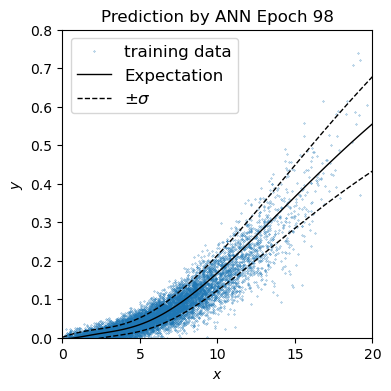

In [151]:
plot_epoch_1D(98)

In [155]:
create_animation(plot_epoch_1D, idx=np.arange(0,100,1), filename='figures/momentum_1D_Batch100_scheduler.gif', FPS=5)

Animation at FPS=5 will last for 20.0 seconds


In [302]:
def plot_epoch_map(epoch=10):
    ''' Input:
            xaxis: the x axis variable to display. The prediction of the mean is then 
            averaged along the other dimensions. 0: wind speed; 1: temp diff. 
    '''
    plt.figure(figsize=(4,3))
    # plt.plot(dataset.X[:2000, xaxis], dataset.Y[:2000], '.', label='training \ndata')
    img = plt.pcolormesh(dataset.X_uniform[:,0].numpy().reshape(100,100), dataset.X_uniform[:,1].numpy().reshape(100,100),
                         log_var['mean'][epoch].reshape(100,100), vmax=1, vmin=0)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
#     plt.legend(loc='upper left', fontsize=12)
    plt.colorbar(img, ticks=[0,1])
    plt.title('Epoch %g' %epoch)

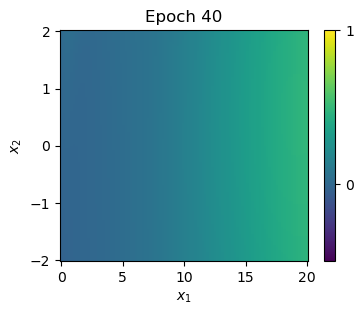

In [296]:
plot_epoch_map(40)

Text(0.5, 1.0, 'True $\\mu$')

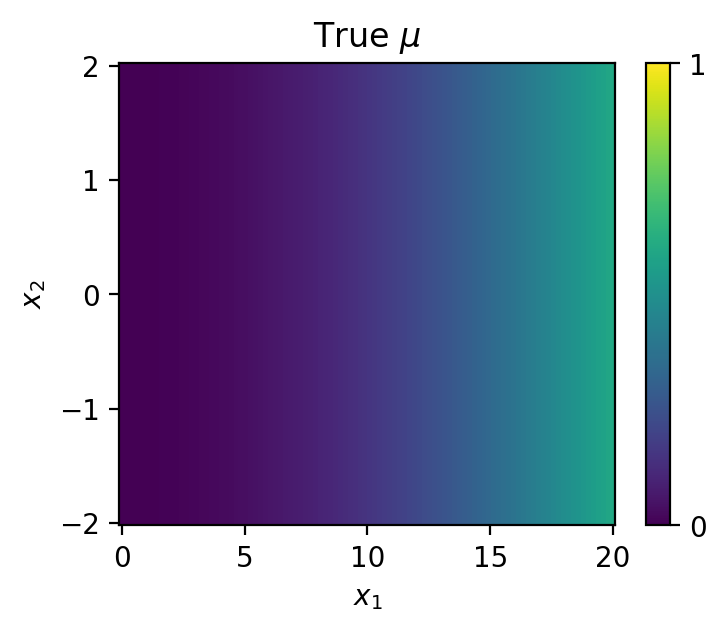

In [280]:
plt.figure(figsize=(4,3), dpi=200)
X = dataset.X_uniform[:,0].numpy().reshape(100,100)
Y = dataset.X_uniform[:,1].numpy().reshape(100,100)
img = plt.pcolormesh(X, Y, 0.0015*X**2, vmax=1, vmin=0)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(img, ticks=[0,1])
plt.title('True $\mu$')

Animation at FPS=10 will last for 5.0 seconds


In [23]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

def create_animation(fun, idx, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [303]:
create_animation(plot_epoch, idx=np.arange(0,50,1), filename='FluxUQ.gif', FPS=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animation at FPS=10 will last for 5.0 seconds


In [ ]:
''' Train mean and then variance on MSE and then variance and mean on MLE ''' 
optimizer = optim.Adam(mean_net.parameters(), lr=1e-3)
num_epochs = 20
log = {'MSE': [], 'mean': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        MSE = ((mean-targets)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    mean = mean_net(dataset.X_uniform)
    log['MSE'].append(MSE_loss)
    log['mean'].append(mean.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.4f}/{dataset.min_MSE:.4f}")
    
    
optimizer = optim.Adam(var_net.parameters(), lr=1e-3)
num_epochs = 30
log_var = {'MSE': [], 'var': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        r2 = (targets-mean)**2
        var = (var_net(inputs))**2 # squared to predict positive variance
        MSE = ((var-r2)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    var = (var_net(dataset.X_uniform))**2
    log_var['MSE'].append(MSE_loss)
    log_var['var'].append(var.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.6f}")
    
